<a href="https://colab.research.google.com/github/FlorianSong/Intro_data_analytics/blob/master/Workshop3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analytics 2019
### Workshop 3 &ndash; Unsupervised Learning: Dimensionality reduction and Clustering &ndash; 14th Nov 2019
##### Taught by: Florian Song, Sophia Yaliraki

Much of today's workshop was taken from https://github.com/ageron/handson-ml2/ which in turn is based on the second edition of an O'Reilly book [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurélien Geron.

### Overview & Outline


#### Topics covered today:
1. Dimensionality reduction
    * The curse of dimensionality
    * Main approaches for dimensionality reduction
    * **PCA** (Principal Component Analysis)
    * *Extra material: PCA for compression*
    * *Extra material: Other Dimensionality Reduction Techniques*
1. Clustering
    * **K-means**
    * *Extra material: More K-Means, K-Means++ and how to choose K*
    * **DBSCAN**
1. Extra material: Other Clustering algorithms 
    * Spectral Clustering
    * Agglomerative Clustering
    * Gaussian Mixtures

Firstly, some house-keeping. We need to check if we have all the necessary libraries installed. For this we can use the following boiler plate code:

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os


import pandas as pd


# to make this notebook's output stable across runs
# np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.datasets import make_swiss_roll, load_iris, fetch_openml, make_blobs, load_wine, make_moons, fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture


# 1. Dimensionality reduction

- Many datasets contain many features, sometimes even thousands or more. This usually makes training models very slow. 
- Dimensionality reduction methods reduce the number of features, turning an intractable problem into a tractable one. 
- They are also useful for *data visualisation*. Reducing the number of dimensions to two or three makes it possible to plot data and visually identify patterns. 
- Sometimes, such methods will also *filter out noise* and unnecessary details, but this is *not* the case in general! 
- **Note: Reducing dimensionality incurs information loss!** This may speed up training, but might make the model worse. 

### The curse of dimensionality

- There is a lot of space in higher dimensions! The below table gives the average distance between two points in a unit n-cube: 

| dimensions n | average distance |
| --- | --- |
| 2 | 0.52 |
| 3 | 0.66 |
| 8 | 1.13 |
| 100 | ~ 4.08 |
| 1,000 | ~ 12.9 | 
| 1,000,000 | ~ 408.25 | 

- (The above is a non-trivial mathematical problem! More information for the curious reader [here](http://mathworld.wolfram.com/HypercubeLinePicking.html).)
- Due to this vast amount of space, the dataset becomes **sparse**. This means that it becomes much easier to find a model that fits the data perfectly. In other words, models are more prone to **overfitting**. 
- Predictions are also much more unreliable, as new instances may be very far away from the training data set, so the model has to **extrapolate**. As the number of dimensions grows, the amount of data we need to generalise accurately grows exponentially.

### Main approaches for dimensionality reduction

- To combat the curse of dimensionality, we need to perform *dimensionality reduction*. 
- There are two main approaches:  The first is projecting the data onto a plane in lower dimensional space, called a **Projection**.
- The second approach is called **Manifold Learning**. 
- Both approaches are best visualised through the swiss roll. See the below code for an example. The first plot shows the 3D swiss roll dataset, the second shows a simple projection onto the plane spanning $x_1$ and $x_2$ and the third plot shows the 2D manifold space, essentially *unrolling* the swiss roll.

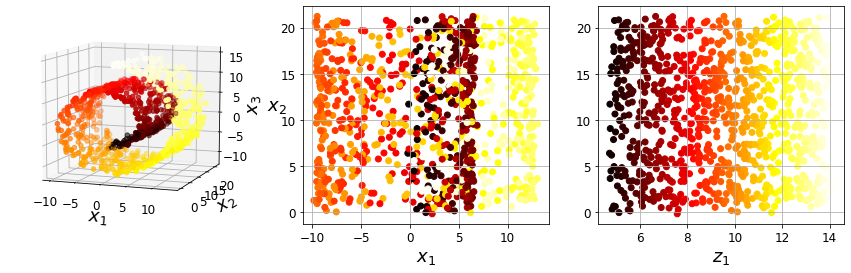

In [2]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2)

fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)

plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(133)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


plt.show()

### PCA (Principle Component Analysis)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/1024px-Singular-Value-Decomposition.svg.png" alt="SVD" width="30%" style="float:right; margin-left=2%">  

- By far the most popular dimensionality reduction algorithm.
- A form of **projection**. Choose the hyperplane that lies closest to the data, then project the data onto it.
- How to choose a *good* hyperplane? 
    * Objective: select the axis that **preserves the maximum amount of variance**, as it will likely lose less information than other projections. 
    * Can do this with *Singular Value Decomposition (SVD)*: $X = U\Sigma V^T$, where $X$ represents the dataset and $V$ contains the unit vectors that define all principal components, i.e. $$
\mathbf{V}^T =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$$
    * Here, $c_i$ represents the $i$<sup>th</sup> *principal component*, all of which are *orthogonal* to each other!
    * $c_1$ is the axis that **accounts for the largest amount of variance**. $c_2$ accounts for the largest amount of the remaining variance, etc... 
    * **Important:** PCA assumes that your data is centered! In `sklearn` this is taken care of automatically. 
    * **Also important**: If your predictors vary wildly in terms of variance, you should *scale* your data. In `sklearn`, this can be done easily by running `X = StandardScaler().fit_transform(X)`. 
- For an intuition of how PCA works, see the figure produced by the code below. 

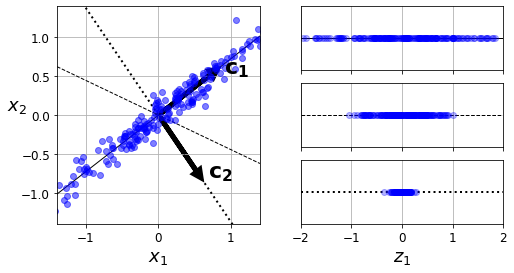

In [3]:
angle = 1.0 * np.pi / 5
stretch = 8
m = 200

X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

With Scikit-Learn, PCA is really trivial.

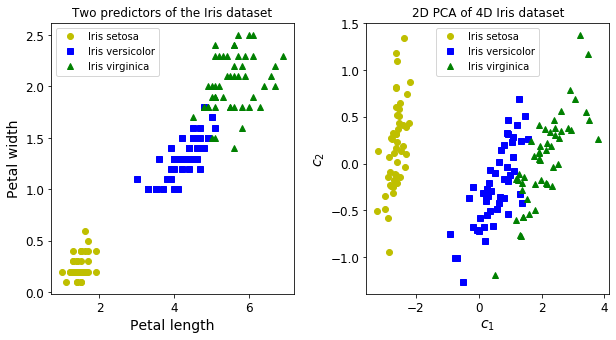

In [4]:
X, y = load_iris(return_X_y=True)

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

## PLOT ####################################
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Two predictors of the Iris dataset')
plt.xlabel("Petal length")
plt.ylabel("Petal width")

plt.subplot(122)
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "yo", label="Iris setosa")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X2D[:, 0][y==2], X2D[:, 1][y==2], "g^", label="Iris virginica")
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('2D PCA of 4D Iris dataset')
plt.xlabel("$c_1$")
plt.ylabel("$c_2$")

plt.subplots_adjust(wspace=0.3)
plt.show()

##### Explained Variance Ratio

The below code will give you the ratio of explained variance of each principal component. In the case of iris, 92.4% of the data's variance lies along $c_1$ and 5.3% lies along $c_2$. 

In [5]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

##### Choosing the right number of dimensions

Simplest is to instruct `PCA` to use as many dimensions as to explain a sufficient (normally 95%) amount of variance. 

In [6]:
pca = PCA(n_components=0.95)
X_95 = pca.fit_transform(X)
X_95[:5]

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451]])

### In-class challenge 1

- Once again, we make use of the `wine` dataset consisting of 13 constituents found in each of three types of wines from different cultivars. 
- Set up a `PCA` on this data set. How much of the variance is explained through the first two principal axes? How many axes do you need to reach 95% of the variance? *Hint if things don't look quite right:* Did you scale your data?
- Plot the raw data (e.g. the Alcohol and Hue predictors) alongside the first two PCA axes. 

[0.36198848 0.1920749  0.11123631 0.0706903  0.06563294 0.04935823
 0.04238679 0.02680749 0.02222153 0.01930019]


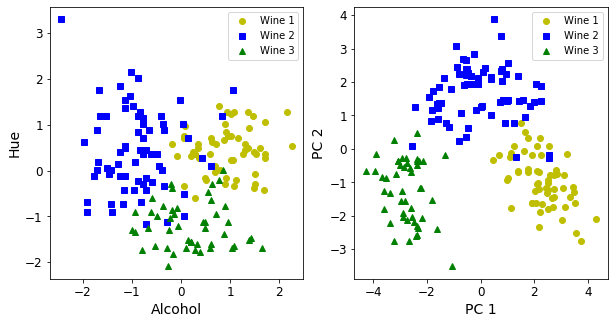

In [7]:
# 3, 2, 1, code!

X_wine, y_wine = load_wine(return_X_y=True)

X_wine = StandardScaler().fit_transform(X_wine)
pca = PCA(n_components=0.95)
X_95 = pca.fit_transform(X_wine)

print(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(X_wine[:, 0][y_wine==0], X_wine[:, 10][y_wine==0], "yo", label="Wine 1")
plt.plot(X_wine[:, 0][y_wine==1], X_wine[:, 10][y_wine==1], "bs", label="Wine 2")
plt.plot(X_wine[:, 0][y_wine==2], X_wine[:, 10][y_wine==2], "g^", label="Wine 3")
plt.legend()
plt.xlabel("Alcohol")
plt.ylabel("Hue")

plt.subplot(122)
plt.plot(X_95[:, 0][y_wine==0], X_95[:, 1][y_wine==0], "yo", label="Wine 1")
plt.plot(X_95[:, 0][y_wine==1], X_95[:, 1][y_wine==1], "bs", label="Wine 2")
plt.plot(X_95[:, 0][y_wine==2], X_95[:, 1][y_wine==2], "g^", label="Wine 3")
plt.legend()
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

### Extra Material: PCA for compression

- An inherent strength of dimensionality reduction is the decrease of space needed to store data. 
- A good example is given below, where images of handwritten digits are compressed. 

In [8]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [9]:
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

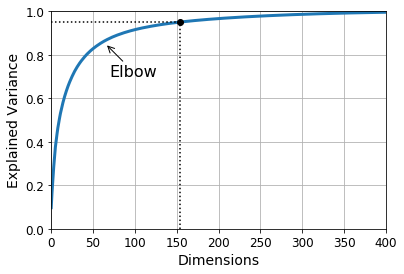

In [10]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [11]:
pca = PCA(n_components=155)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

np.sum(pca.explained_variance_ratio_)

0.9504413318785775

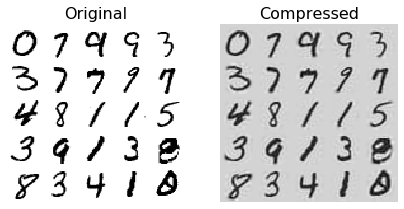

In [12]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

plt.show()

### Extra material: Other Dimensionality Reduction methods

PCA is part of the family of *Projections*. The methods below are *Manifold Learning* algorithms. For more information, see here: https://scikit-learn.org/stable/modules/manifold.html. 

- Locally Linear Embedding (LLE)
- Multidimensional Scaling (MDS)
- Isomap
- t-Distributed Stochastic Neighbor Embedding (t-SNE)

*Care:* The code below many take some time to run!

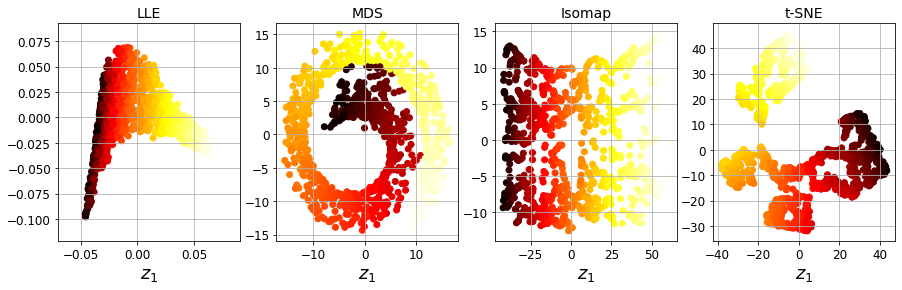

In [13]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2)

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced_lle = lle.fit_transform(X)

mds = MDS(n_components=2)
X_reduced_mds = mds.fit_transform(X)

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(X)


titles = ["LLE", "MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(15,4))

for subplot, title, X_reduced in zip(range(141, 145), titles,
                                     (X_reduced_lle, X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# 2. Clustering

- *Clustering* is the task of identifying similar instances and assigning them to *clusters*. In other words, it is the *unsupervised learning* counterpart of *classification*. 
- **There is no universal definition of what a cluster is!** Which algorithm to use will depend on context, as different algorithms may capture different kinds of clusters:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" alt="clustering" width="90%" />

- The code below will show you that clustering can be very good at retrieving ground truths about data, using a familiar dataset: iris. 

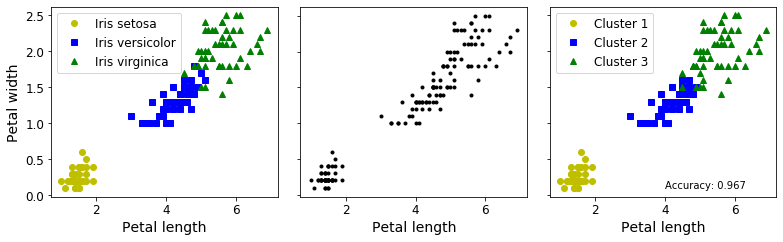

In [14]:
X, y = load_iris(return_X_y=True)
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])



plt.figure(figsize=(13, 3.5))

plt.subplot(131)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(132)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)


plt.subplot(133)
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.tick_params(labelleft=False)
plt.text(4, 0.1, "Accuracy: {}".format(round(accuracy_score(y_pred, y),3)))

plt.subplots_adjust(wspace=0.1)
plt.show()

###  K-Means

- A simple but effective and very quick algorithm capable of clustering large datasets, originally proposed by Stuart Lloyd at Bell Labs in 1957. 
- **Big caveat:** The number of clusters needs to be specified beforehand.

In [15]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

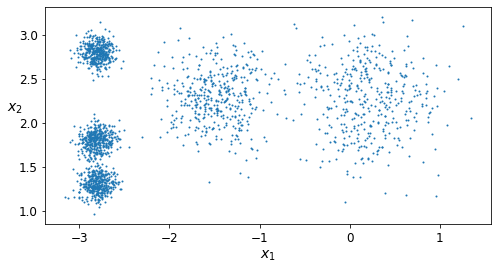

In [16]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

#####  Fit and Predict

Again `sklearn` provides an easy to use implementation:

In [17]:
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

y_pred # aka kmeans.labels_

array([3, 4, 2, ..., 1, 2, 4], dtype=int32)

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [18]:
kmeans.cluster_centers_

array([[-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [ 0.20876306,  2.25551336],
       [-2.80037642,  1.30082566],
       [-2.80389616,  1.80117999]])

In [19]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([2, 2, 1, 1], dtype=int32)

##### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a *Voronoi diagram*:

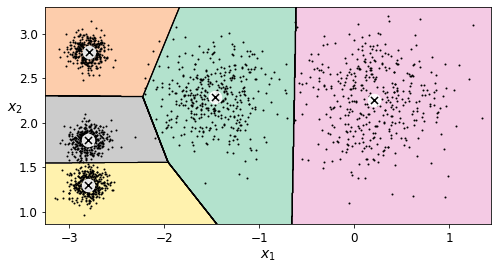

In [20]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
        
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

###  Extra material: More K-Means, K-Means++ and how to choose K

##### Hard Clustering _vs_ Soft Clustering

Rather than arbitrarily choosing the closest cluster for each instance, which is called *hard clustering*, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [21]:
print("Reminder:", kmeans.predict(X_new))
kmeans.transform(X_new)

Reminder: [2 2 1 1]


array([[1.49439034, 2.9042344 , 0.32995317, 2.88633901, 2.81093633],
       [4.4759332 , 5.84739223, 2.80290755, 5.84236351, 5.80730058],
       [1.69136631, 0.29040966, 3.29399768, 1.71086031, 1.21475352],
       [1.54808703, 0.36159148, 3.21806371, 1.21567622, 0.72581411]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [22]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[1.49439034, 2.9042344 , 0.32995317, 2.88633901, 2.81093633],
       [4.4759332 , 5.84739223, 2.80290755, 5.84236351, 5.80730058],
       [1.69136631, 0.29040966, 3.29399768, 1.71086031, 1.21475352],
       [1.54808703, 0.36159148, 3.21806371, 1.21567622, 0.72581411]])

##### K-Means algorithm

- The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
    * First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
    * Repeat until convergence (i.e., until the centroids stop moving):
        * Assign each instance to the closest centroid.
        * Update the centroids to be the mean of the instances that are assigned to them.
- The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [23]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

And let's plot this:

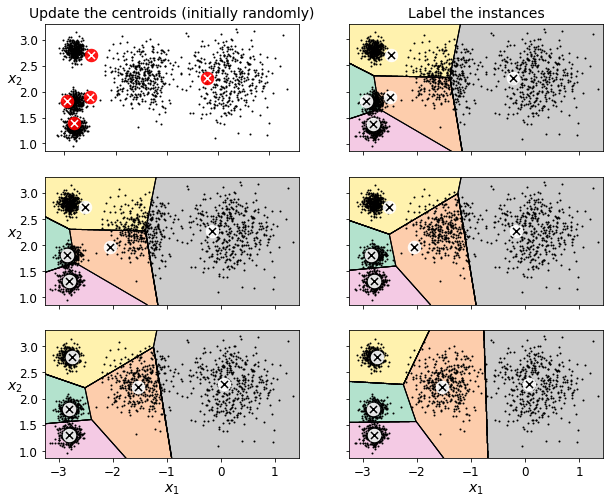

In [24]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

##### K-Means Variability

- In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.
- However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [25]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

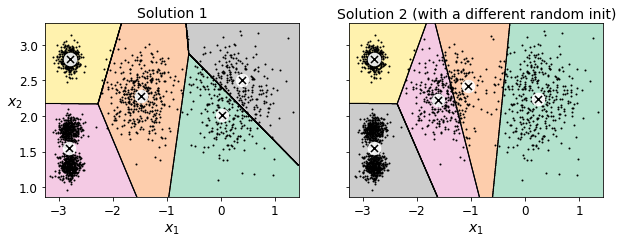

In [26]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

##### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [27]:
kmeans.inertia_

211.5985372581684

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [28]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_great is better_" rule.

In [29]:
kmeans.score(X)

-211.59853725816856

##### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [30]:
kmeans_rnd_init1.inertia_

223.29108572819035

In [31]:
kmeans_rnd_init2.inertia_

237.46249169442845

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [32]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=11,
       tol=0.0001, verbose=0)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

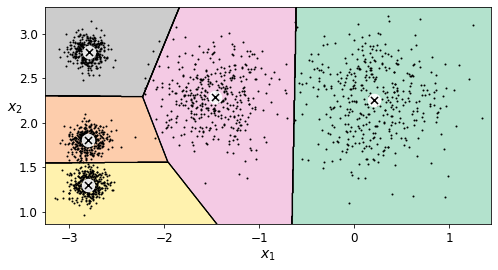

In [33]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

##### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [34]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [35]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

##### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

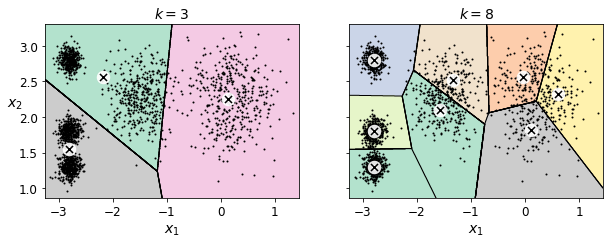

In [36]:
kmeans_k3 = KMeans(n_clusters=3)
kmeans_k8 = KMeans(n_clusters=8)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [37]:
kmeans_k3.inertia_

653.2167190021553

In [38]:
kmeans_k8.inertia_

118.36128070969806

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [39]:
kmeans_per_k = [KMeans(n_clusters=k).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

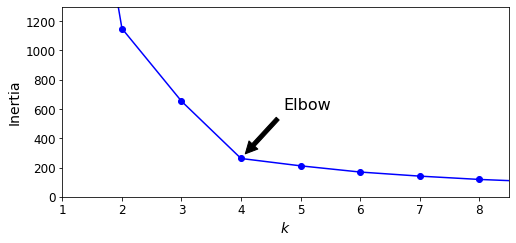

In [40]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

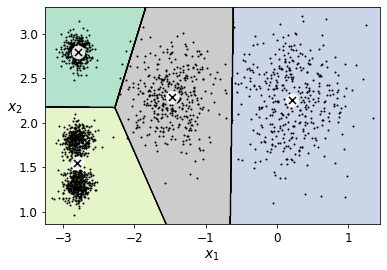

In [41]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the *silhouette score*, which is the mean *silhouette coefficient* over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the *mean intra-cluster distance*), and $b$ is the *mean nearest-cluster distance*, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [42]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

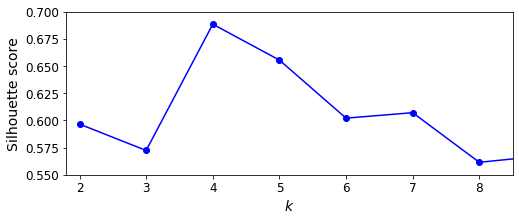

In [43]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

##### Limits of K-Means

Sadly, despite its strengths, KMeans has its drawbacks. Notably, things start going pear-shaped when clusters have varying sizes, different densities or non-spherical shapes, as you can see below: 

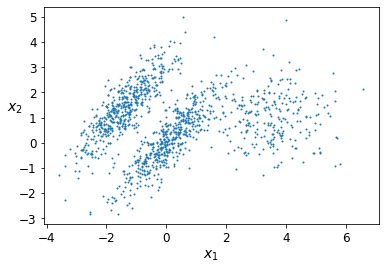

In [44]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_clusters(X)

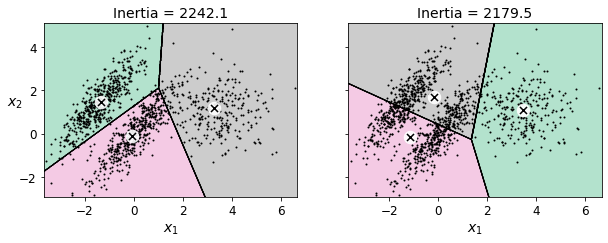

In [45]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

##### Using clustering for image segmentation

*Care:* The code below may take a while to run!

In [46]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://www.imperial.ac.uk/ImageCropToolT4/imageTool/uploaded-images/CDT---Faculty--tojpeg_1572014100640_x1.jpg")
img = Image.open(BytesIO(response.content))

image = np.array(img)
image.shape

(431, 959, 3)

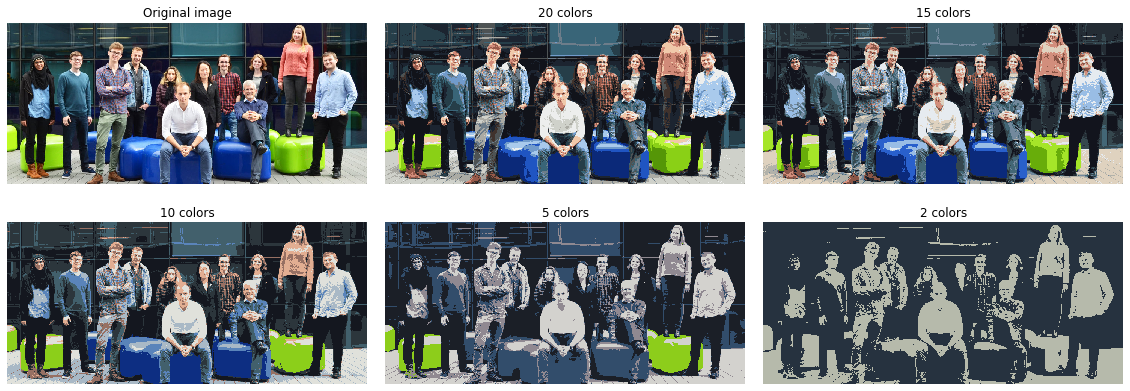

In [47]:
X = image.reshape(-1, 3)

segmented_imgs = []
n_colors = (20, 15, 10, 5, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape)/255)

plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1280px-DBSCAN-Illustration.svg.png" alt="DBSCAN" width="50%" style="float: right; margin-left: 3%;"/>

- DBSCAN defines clusters as continuous regions of high density.
- Here is how it works: 
    * For each instance, count how many other instances are within a distance $\epsilon$ from it. (*$\epsilon$-neighbourhood*)
    * If an instance has at least `min_samples` (=4 in the picture) in its $\epsilon$-neighbourhood, it is a *core instance*. In the picture, all <span style="color:red">red points near A</span> are core instances. 
    * Core instances that are *reachable* from another core instance belong to the same cluster. 
    * <span style="color:orange">Points B and C</span> are not core instances themselves, but are *reachable* from some core instance, and thus also belong to that cluster. 
    * <span style="color:blue">Points N</span> is neither a core instance, nor reachable from any core instance and hence it is labelled as *noise*. 
- DBSCAN works well if clusters are dense enough and if they are well separated by low-density regions. 


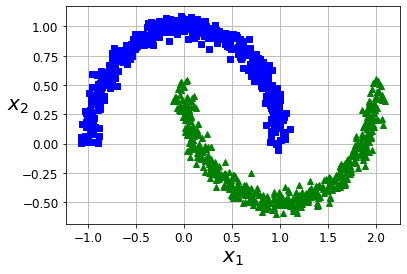

In [48]:
X, y = make_moons(n_samples=1000, noise=0.05)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.grid(True, which='both')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.show()

In [49]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
np.unique( dbscan.labels_ )

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [50]:
len(dbscan.core_sample_indices_) # How many core instances?

804

In [51]:
dbscan.core_sample_indices_[:10] # At which positions of the original data?

array([ 0,  1,  2,  3,  5,  7,  8,  9, 10, 11])

In [52]:
dbscan.components_[:3] # What are the core instances?

array([[-0.30727514,  0.91350241],
       [ 0.8474294 , -0.4946923 ],
       [ 0.42033595, -0.3551219 ]])

In [53]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

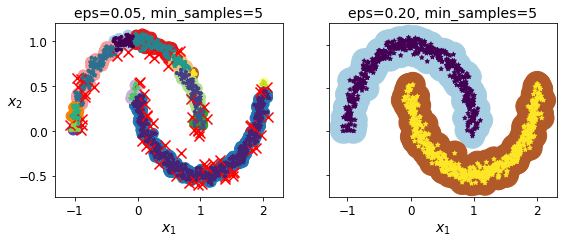

In [54]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)
    
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()


Perhaps surprisingly, `DBSCAN` does *not* have a `predict()` method! Instead, you have to train a classification algorithm to do that. 

In [55]:
dbscan_svm = DBSCAN(eps=0.2)
dbscan_svm.fit(X)

svm = SVC(kernel="rbf", gamma="scale", probability=True) # n_neighbors=50)
svm.fit(dbscan_svm.components_, dbscan_svm.labels_[dbscan_svm.core_sample_indices_])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [56]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
svm.predict(X_new)

array([1, 1, 0, 1])

In [57]:
svm.predict_proba(X_new)

array([[0.04691244, 0.95308756],
       [0.02548291, 0.97451709],
       [0.82707375, 0.17292625],
       [0.03118538, 0.96881462]])

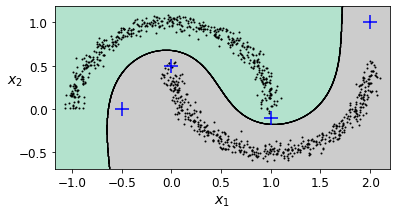

In [58]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(svm, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

### In-class challenge 2

<img src="https://cs.nyu.edu/~roweis/data/olivettifaces.gif" alt="olivetti" width="30%" style="float: right; margin-left: 2%;"/>

- For the final in-class challenge today, we are doing some facial recognition!
- To this end, you have been given some code to start you off with the all-time popular `Olivetti` faces dataset, consisting of 400 picture, 10 pictures of each of 40 people. More information can be found by calling `print(olivetti.DESCR)` or [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html).
- As you can see, the olivetti object contains three datasets: `data`, `images` and `target`. The `images` data simply contains a 400x64x64 array describing 400 black-white images with 64 pixels wide and 64 pixels high. You can use this alongside the command `plt.imshow(..., cmap="gray")` to visualise the image in grayscale. The `data` contains a 400x4096 matrix, which is just the flattened version of the above. Finally the `target` vector describes the ground truth and contains `0` for the first person, `1` for the second person, and so on. 
- Use `KMeans` to cluster the data. Extract the cluster labels and visualise the pictures belonging to a cluster. *Hint:* You might find the function `np.where(<condition>)` useful. 
- Do you see similar faces in each cluster? What happens when you vary the number of clusters in K-Means?

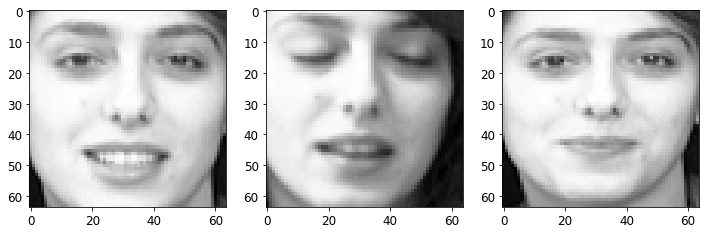

In [59]:
olivetti = sklearn.datasets.fetch_olivetti_faces()
data, images, target = olivetti["data"], olivetti["images"], olivetti["target"]
# print(olivetti.DESCR)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(images[75], cmap='gray')
plt.subplot(132)
plt.imshow(images[76], cmap='gray')
plt.subplot(133)
plt.imshow(images[77], cmap='gray')

plt.show()

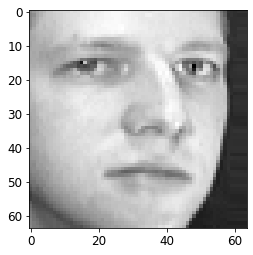

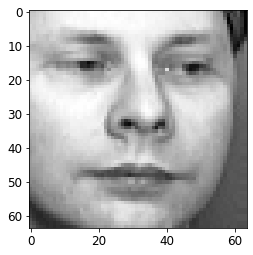

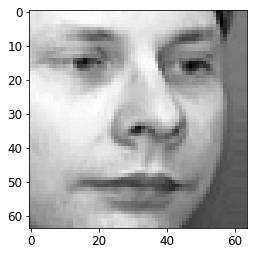

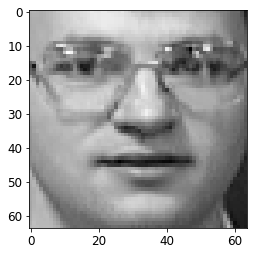

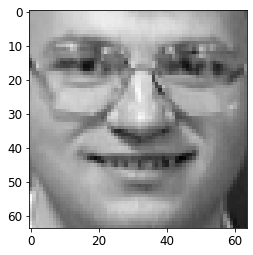

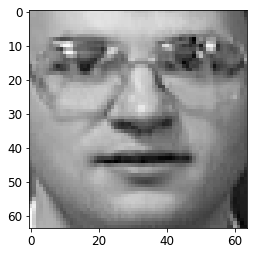

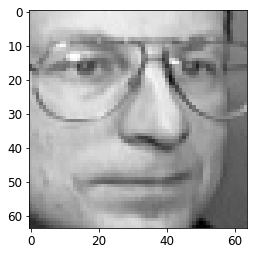

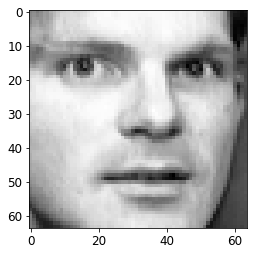

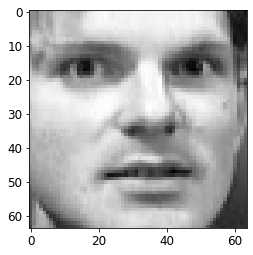

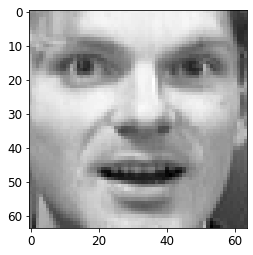

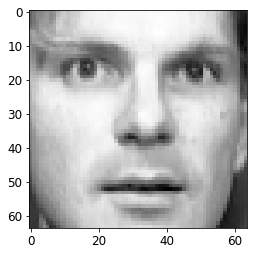

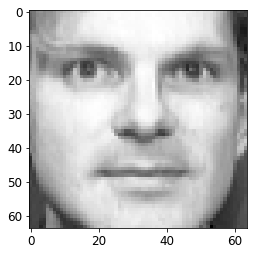

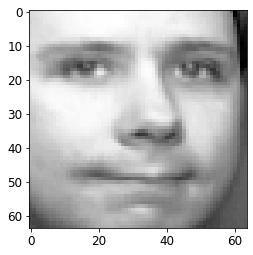

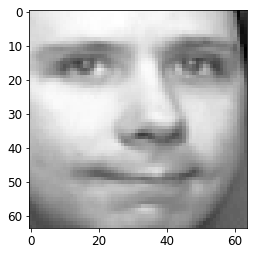

In [60]:
# 3, 2, 1, code!

kmeans = KMeans(40)
kmeans.fit(data)

for i in np.where(kmeans.labels_ == 3)[0]:
    plt.imshow(images[i], cmap="gray")
    plt.show()

# 3. Extra material: Other Clustering Algorithms

### Spectral Clustering

More information: https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering

In [61]:
X, y = make_moons(n_samples=1000, noise=0.05)

sc1 = SpectralClustering(n_clusters=2, gamma=100)
sc1.fit(X)

sc2 = SpectralClustering(n_clusters=2, gamma=1)
sc2.fit(X)

np.percentile(sc1.affinity_matrix_, 95)

0.042607372212473335

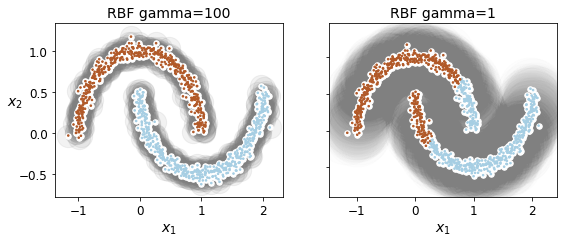

In [62]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

    
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Agglomerative Clustering

More information: https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

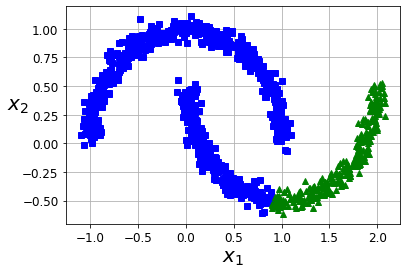

In [63]:
X, y = make_moons(n_samples=1000, noise=0.05)

agg = AgglomerativeClustering(linkage="complete").fit(X)

y = agg.labels_

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.grid(True, which='both')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.show()

### Gaussian Mixtures

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

More information: https://scikit-learn.org/stable/modules/mixture.html

In [64]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)))
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [65]:
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Let's look at the parameters that the EM algorithm estimated:

In [66]:
gm.weights_

array([0.40033877, 0.2       , 0.39966123])

In [67]:
gm.means_

array([[-0.02609035, -0.08081948],
       [10.09347039, -7.30049153],
       [-1.36037036,  1.53167245]])

In [68]:
gm.covariances_

array([[[0.71359561, 0.85365763],
        [0.85365763, 1.37137691]],

       [[1.07478017, 0.01134205],
        [0.01134205, 1.03175439]],

       [[0.66912615, 0.79554605],
        [0.79554605, 1.28019817]]])

Did the algorithm actually converge?

In [69]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [70]:
gm.n_iter_

20

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [71]:
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1])

In [72]:
gm.predict_proba(X)

array([[9.99999016e-001, 4.01944062e-034, 9.84088747e-007],
       [9.99999966e-001, 2.30417773e-033, 3.35102769e-008],
       [2.82754226e-010, 4.26242119e-047, 1.00000000e+000],
       ...,
       [1.21476648e-232, 1.00000000e+000, 0.00000000e+000],
       [1.15350381e-248, 1.00000000e+000, 0.00000000e+000],
       [4.50644498e-247, 1.00000000e+000, 0.00000000e+000]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [73]:
X_new, y_new = gm.sample(6)
X_new

array([[11.59859167, -8.06643408],
       [ 9.28244058, -6.03560925],
       [10.55506448, -6.21484242],
       [-0.79924232,  1.10834669],
       [-1.6051797 ,  1.80210855],
       [-1.68384674,  1.36022597]])

In [74]:
y_new

array([1, 1, 1, 2, 2, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [75]:
gm.score_samples(X)

array([-2.28299024, -2.35765144, -2.68458636, ..., -4.46988229,
       -3.70764885, -3.70767989])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [76]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.8920645498020876

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [77]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

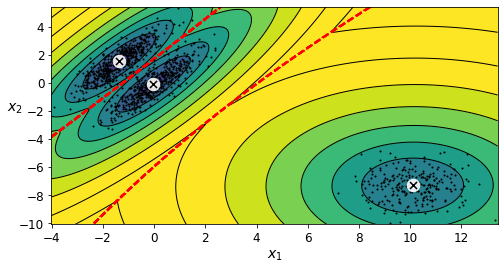

In [78]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

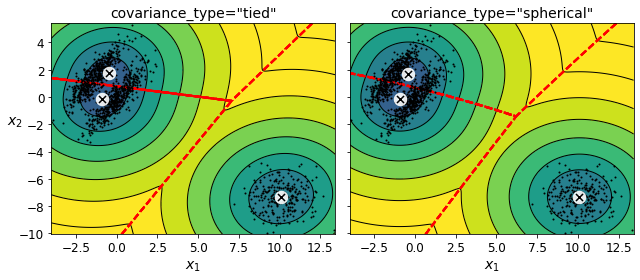

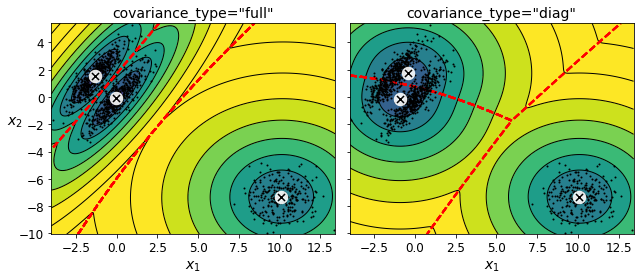

In [79]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full")
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied")
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical")
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag")
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)


def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.tight_layout()
plt.show()

compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()



##### Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for *anomaly detection*: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [80]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

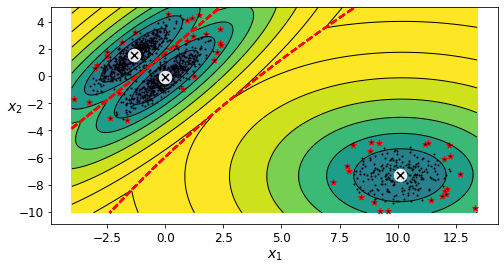

In [81]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

# Take-home challenge: Exploring the ChEMBL small molecule database

- This week, we will have a look at the data contained in the [ChEMBL](https://www.ebi.ac.uk/chembl/) database. 
- According to [Wikipedia](https://en.wikipedia.org/wiki/ChEMBL), ChEMBL or ChEMBLdb is a manually curated chemical database of bioactive molecules with drug-like properties. It is maintained by the European Bioinformatics Institute (EBI), of the European Molecular Biology Laboratory (EMBL), based at the Wellcome Trust Genome Campus, Hinxton, UK.
- Firstly, take some time to familiarise yourself with the database. To browse all compounds available, click [here](https://www.ebi.ac.uk/chembl/g/#browse/compounds). If you're unsure about how the various molecule properties are defined, you can have a look [here](https://www.dropbox.com/s/mixm4cn5x7azmg4/property_definitions.docx?dl=0).
- Next, download a csv file of all compounds with a molecular weight *less than 200*. This should keep the dataset reasonably small to do some exploratory analysis. In case you're having trouble doing that, you can also download the file [here](https://github.com/FlorianSong/Intro_data_analytics/blob/master/CHEMBL_200.csv).
- Finally, the rest of this challenge is completely open-ended! Play around with the data and see which variables make sense to focus on (all numeric variables or just some?). Try using dimensionality reduction to make the data more accessible to various models. What happens when you cluster the data? Can you find any trends in the clusters? 
- There is no correct answer here, but some are better than others.

Credit: Inspiration for this challenge was taken from [here](https://github.com/nebarlow/machine_learning_for_chem_bio). 

In [82]:
import pandas as pd
chembl = pd.read_csv("datasets/CHEMBL_200.csv", sep = ";")

# A selection of basic predictors
columns = ['Molecular Weight', 'Bioactivities', 'AlogP','PSA','HBA','HBD','#Rotatable Bonds', "Heavy Atoms", "Aromatic Rings"]

# Use this line to get all columns of type float
# columns = chembl.columns[np.where(chembl.dtypes == "float64")] 

chembl_subset = chembl[columns].dropna()
chembl_subset

,Molecular Weight,Bioactivities,AlogP,PSA,HBA,HBD,#Rotatable Bonds,Heavy Atoms,Aromatic Rings
4170,176.27,58.0,0.45,48.78,6.0,2.0,0.0,10.0,0.0
4171,178.23,1.0,1.99,35.01,3.0,0.0,4.0,13.0,1.0
4172,178.21,9.0,0.67,74.60,3.0,2.0,6.0,11.0,0.0
4173,137.16,2.0,-0.39,46.97,1.0,1.0,1.0,10.0,1.0
4174,164.16,33.0,0.27,55.02,4.0,0.0,1.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...
34647,191.23,7.0,1.67,38.66,3.0,0.0,3.0,14.0,1.0
34648,181.20,3.0,-0.71,77.16,6.0,1.0,1.0,13.0,1.0
34649,190.25,1.0,1.66,23.55,2.0,0.0,1.0,14.0,1.0
34650,119.12,1.0,-1.22,83.55,3.0,3.0,2.0,8.0,0.0


In [83]:
chembl.dtypes

ChEMBL ID                           object
Name                                object
Synonyms                            object
Type                                object
Max Phase                            int64
Molecular Weight                   float64
Targets                              int64
Bioactivities                      float64
AlogP                              float64
PSA                                float64
HBA                                float64
HBD                                float64
#RO5 Violations                    float64
#Rotatable Bonds                   float64
Passes Ro3                          object
QED Weighted                       float64
ACD ApKa                           float64
ACD BpKa                           float64
ACD LogP                           float64
ACD LogD                           float64
Aromatic Rings                     float64
Structure Type                      object
Inorganic Flag                       int64
Heavy Atoms

In [84]:
X_subchembl = chembl_subset.to_numpy()


# PCA 
X_subchembl_scaled = StandardScaler().fit_transform(X_subchembl)
X_subchembl_pca = PCA(n_components=0.9).fit_transform(X_subchembl_scaled)
X_subchembl_pca

array([[ 1.68738443,  0.43088688,  1.07584326,  0.1715543 ,  1.48873561,
         0.86795631],
       [-1.0503503 , -0.85466314, -1.21874964,  0.06097014,  0.93797514,
        -0.77258216],
       [ 1.57579282,  0.10540756, -2.60322136,  0.26505378,  0.07783195,
        -0.82332167],
       ...,
       [-1.71684939, -0.93686136,  0.01131534, -0.11318658,  0.41341939,
         0.8229923 ],
       [ 2.65515569,  2.77329787,  0.09535354, -0.32167196, -0.50510941,
        -0.39804064],
       [ 0.84595374,  1.65381068,  0.46603029, -0.27551031, -0.30882396,
        -1.12714253]])

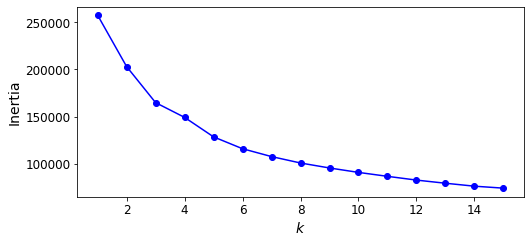

In [85]:
# KMeans
range_of_ks = range(1,16)
kmeans_per_k = [KMeans(n_clusters=k).fit(X_subchembl_pca) for k in range_of_ks]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

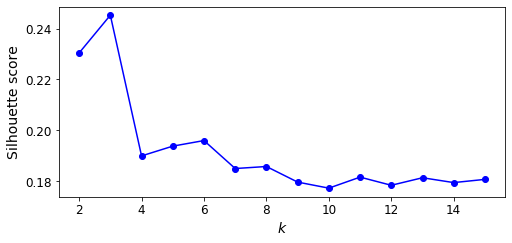

In [86]:
silhouette_scores = [silhouette_score(X_subchembl_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3.5))
plt.plot(range_of_ks[1:], silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [87]:
y_subchembl = KMeans(3).fit_predict(X_subchembl_pca)
y_subchembl

array([2, 0, 2, ..., 0, 2, 1], dtype=int32)

In [88]:
rndfor = RandomForestClassifier(n_estimators=500)
rndfor.fit(X_subchembl, y_subchembl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [89]:
for name, imp in zip(chembl_subset.columns, rndfor.feature_importances_):
    print(name.ljust(20), round(imp,2))

Molecular Weight     0.21
Bioactivities        0.01
AlogP                0.2
PSA                  0.24
HBA                  0.05
HBD                  0.06
#Rotatable Bonds     0.02
Heavy Atoms          0.17
Aromatic Rings       0.04


In [90]:
tsne = TSNE().fit_transform(X_subchembl_pca)

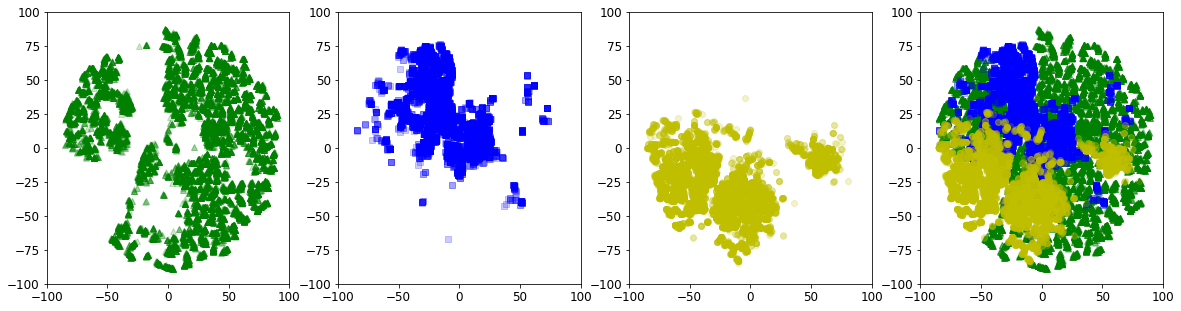

In [91]:
plt.figure(figsize=(20,5))

plt.subplot(141)
plt.plot(tsne[:,0][y_subchembl==0], tsne[:,1][y_subchembl==0], "g^", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(142)
plt.plot(tsne[:,0][y_subchembl==1], tsne[:,1][y_subchembl==1], "bs", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(143)
plt.plot(tsne[:,0][y_subchembl==2], tsne[:,1][y_subchembl==2], "yo", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(144)
plt.plot(tsne[:,0][y_subchembl==0], tsne[:,1][y_subchembl==0], "g^", alpha=0.2)
plt.plot(tsne[:,0][y_subchembl==1], tsne[:,1][y_subchembl==1], "bs", alpha=0.2)
plt.plot(tsne[:,0][y_subchembl==2], tsne[:,1][y_subchembl==2], "yo", alpha=0.2)
plt.axis([-100, 100, -100, 100])

plt.show()